## Importing necessary libraries 

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import voxelmorph as vxm
import neurite as ne
import cv2
import matplotlib.pyplot as plt
from image_registration import chi2_shift

## Load Data from numpy file

In [2]:
npz = np.load("Documents/brain_image_fusion/registration_brain/tutorial_data.npz")

In [3]:
x_train = npz["train"]
x_val = npz["validate"]

## Shape of x train and x validation 

In [4]:
x_train.shape,x_val.shape               #number of train images = 208    number of validation images = 141

((208, 192, 160), (141, 192, 160))

In [5]:
vol_shape = x_train.shape[1:]          #It shows the size(volume) of all images

In [6]:
vol_shape

(192, 160)

In [7]:
# print(x_train[np.newaxis,...,np.newaxis].shape)

## Visualize some of the random images  

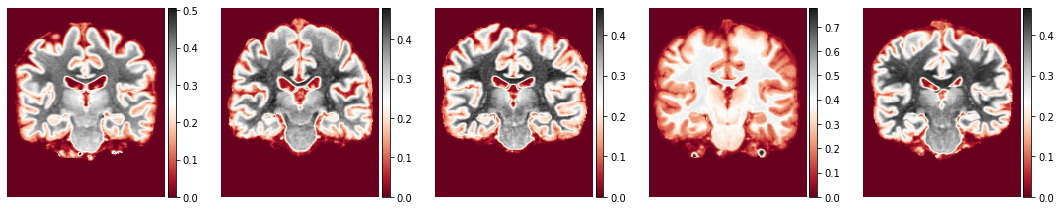

(<Figure size 1080x216 with 10 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>], dtype=object))

In [7]:
idx = np.random.randint(0, x_train.shape[0], 5)
random_images = [i for i in x_train[idx]]

ne.plot.slices(random_images, cmaps = ["RdGy"] , do_colorbars=True)

## Configure Unet features 

In [8]:
nb_features = [
    [32,32,32,32],              #encoder features
    [32,32,32,32,32,16]         #decoder features 
]

### The Voxelmorph provide VxmDense model for building dense deformation networks. This model automatically configures with two input tensors (moving and fixed inputs).
### This inbuilt model comprise of dense VoxelMorph archetechture with a Unet component, displacement field and a final spatial transformer layer.
### Here we use mean square error as our 1st loss function. And for the second loss here I use spatial gradeint of the displacement
### The int_steps = 0 disables diffeomorphism. 

In [9]:
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps = 0)

losses = [vxm.losses.MSE().loss, vxm.losses.Grad("l2").loss]
loss_weights = [1,0.01]   ## Balance the two losses by this hyper-parameter.

Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [13]:
vxm_model.summary()

Model: "vxm_dense"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
source_input (InputLayer)       [(None, 192, 160, 1) 0                                            
__________________________________________________________________________________________________
target_input (InputLayer)       [(None, 192, 160, 1) 0                                            
__________________________________________________________________________________________________
unet_input_concat (Concatenate) (None, 192, 160, 2)  0           source_input[0][0]               
                                                                 target_input[0][0]               
__________________________________________________________________________________________________
unet_enc_conv_0_0 (Conv2D)      (None, 192, 160, 32) 608         unet_input_concat[0][0]  

In [14]:
print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))

input shape:  (None, 192, 160, 1), (None, 192, 160, 1)
output shape: (None, 192, 160, 1), (None, 192, 160, 2)


### Compile the model 

In [15]:
vxm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss = losses, loss_weights = loss_weights)

### Additional information  

In [36]:
x = np.zeros([1, *(192,160), 2])
x.shape

(1, 192, 160, 2)

In [22]:
x_train.shape[0]

208

In [24]:
np.random.randint(0, x_train.shape[0], 1)

array([121])

In [26]:
x_train[121, ..., np.newaxis].shape

(192, 160, 1)

In [30]:
inp = [x_train[1, ..., np.newaxis],x_train[2, ..., np.newaxis]]

In [34]:
inp[0].shape, inp[1].shape, len(inp)

((192, 160, 1), (192, 160, 1), 2)

### Before training our model we need to make sure that the data is in the right format. So for this we require a python generator that gives batches of data.  
### Yield is used in place of return because when we resumed, the function continues execution immediately after the last yield run. This allows its code to produce a series of values over time, rather than computing them at once and sending them back like a list.

In [46]:
def vxm_data_generator(x_data, batch_size = 1):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    
    """
    
    vol_shape = x_data.shape[1:]      #(192, 160)
    ndims = len(vol_shape)            # 2
    
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])  # (1,192,160,2) : - This is used to represent flow
    
    while True:
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)        #It gives a random value between (0 to 208)
        moving_images = x_data[idx1, ..., np.newaxis]                       #It has a shape of (192,160,1)
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]                       #list of 2 images having shape (192,160,1) and (192,160,1)
        
        outputs = [fixed_images, zero_phi]                       # It has a shape of (192,160,1) and (1,192,160,2)
        
        yield (inputs, outputs)   

## Additional Information 

In [63]:
t1 = vxm_data_generator(x_train)
(next(t1)[0][0].shape), (next(t1)[0][1].shape), (next(t1)[1][0].shape), (next(t1)[1][1].shape)

((1, 192, 160, 1), (1, 192, 160, 1), (1, 192, 160, 1), (1, 192, 160, 2))

In [75]:
in_, out_ = next(t1)

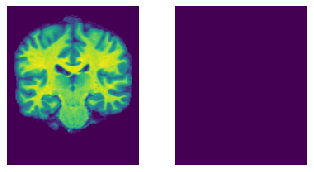

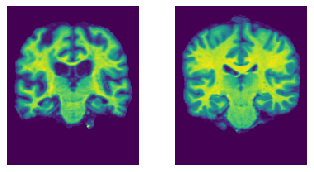

(<Figure size 360x180 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

In [77]:
images1 =[i[0,:,:,0] for i in out_]
ne.plot.slices(images1, width = 5)

images2 = [i[0,:,:,0] for i in in_]
ne.plot.slices(images2, width = 5)

## Visualise some images with flow  

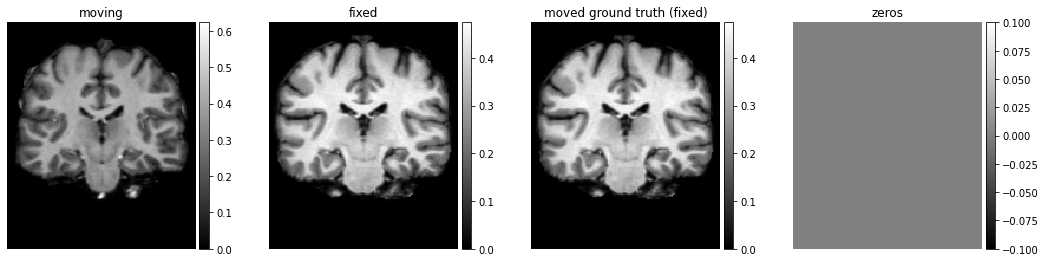

(<Figure size 1080x270 with 8 Axes>,
 array([<AxesSubplot:title={'center':'moving'}>,
        <AxesSubplot:title={'center':'fixed'}>,
        <AxesSubplot:title={'center':'moved ground truth (fixed)'}>,
        <AxesSubplot:title={'center':'zeros'}>], dtype=object))

In [48]:
train_generator = vxm_data_generator(x_train)
in_sample, out_sample = next(train_generator)

images = [img[0,:,:,0] for img in in_sample + out_sample]
titles = ["moving", "fixed", "moved ground truth (fixed)", "zeros"]
ne.plot.slices(images, titles=titles, cmaps=["gray"], do_colorbars=True)

## Train the model and visualise the different types of loss using tensorboard 

In [15]:
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph_mri1', histogram_freq=0, write_graph=True, write_images=True)
hist = vxm_model.fit(train_generator, epochs=10, steps_per_epoch=5, verbose=2, callbacks=[tbCallBack])

Epoch 1/10
5/5 - 33s - loss: 0.0074 - transformer_loss: 0.0074 - flow_loss: 2.3535e-07
Epoch 2/10
5/5 - 27s - loss: 0.0069 - transformer_loss: 0.0069 - flow_loss: 2.8032e-06
Epoch 3/10
5/5 - 27s - loss: 0.0072 - transformer_loss: 0.0072 - flow_loss: 1.4137e-05
Epoch 4/10
5/5 - 27s - loss: 0.0067 - transformer_loss: 0.0067 - flow_loss: 5.2694e-05
Epoch 5/10
5/5 - 27s - loss: 0.0072 - transformer_loss: 0.0072 - flow_loss: 9.5308e-05
Epoch 6/10
5/5 - 27s - loss: 0.0073 - transformer_loss: 0.0073 - flow_loss: 6.7020e-05
Epoch 7/10
5/5 - 27s - loss: 0.0068 - transformer_loss: 0.0068 - flow_loss: 4.3879e-05
Epoch 8/10
5/5 - 27s - loss: 0.0070 - transformer_loss: 0.0070 - flow_loss: 4.5542e-05
Epoch 9/10
5/5 - 27s - loss: 0.0066 - transformer_loss: 0.0066 - flow_loss: 6.1573e-05
Epoch 10/10
5/5 - 27s - loss: 0.0068 - transformer_loss: 0.0068 - flow_loss: 7.1781e-05


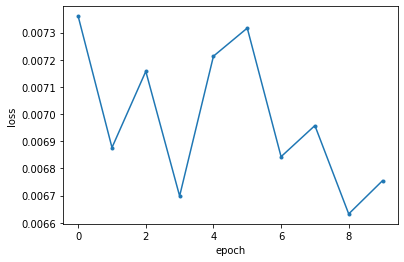

In [16]:
def plot_history(hist, loss_name = "loss"):
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], ".-")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.show()
    
plot_history(hist)

## Train a model with epoch = 200 for better result. Here we are loading a pretrained model for this

In [17]:
vxm_model.load_weights("Desktop/registration_brain/brain_2d_smooth.h5")

## Here we generate data for validation set and predict the value and then compare the results

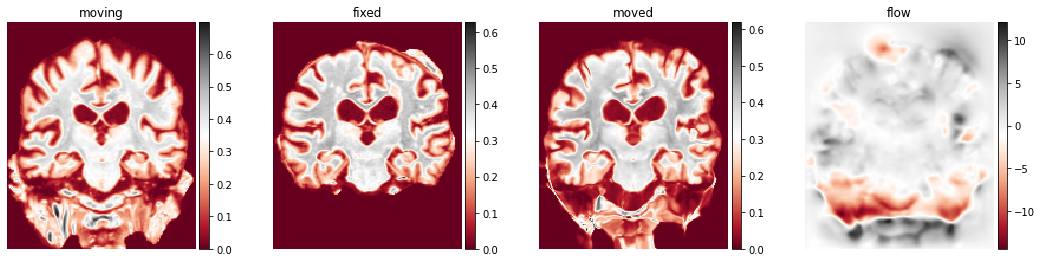

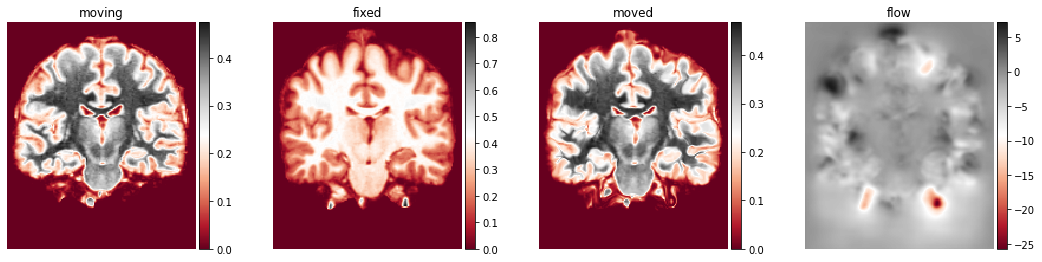

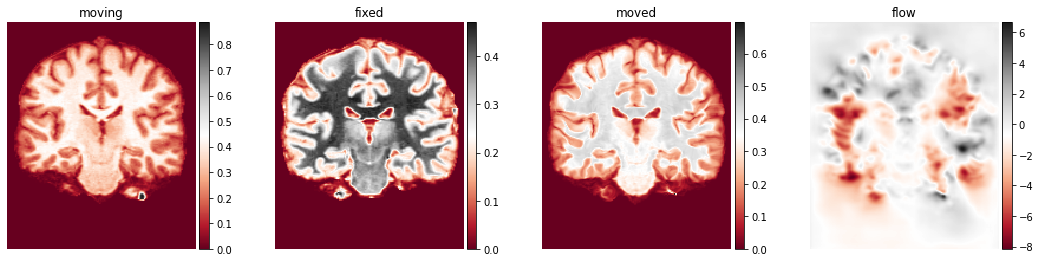

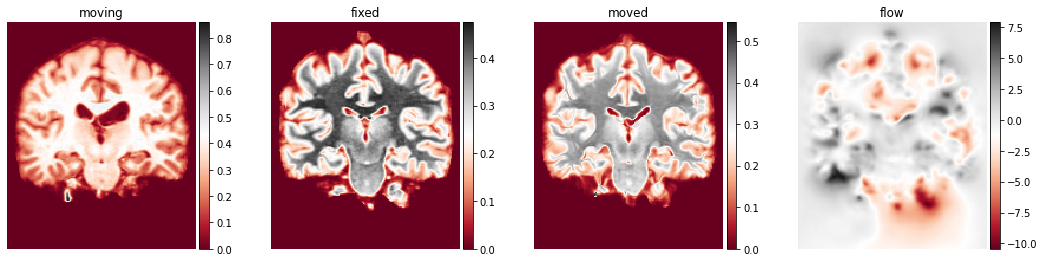

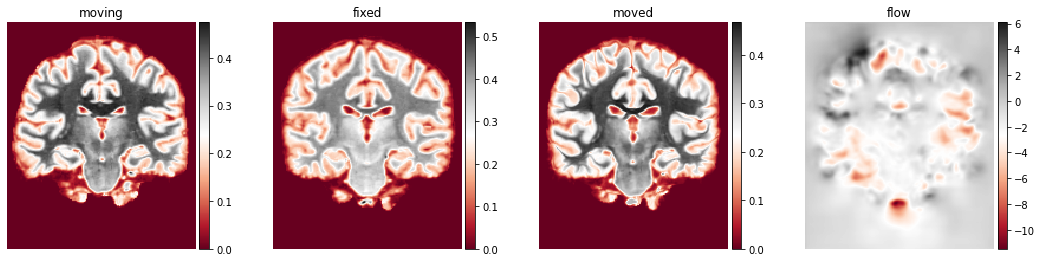

In [18]:
val_generator = vxm_data_generator(x_val, batch_size = 1)

for i in range(5):
    val_input,_ = next(val_generator)                          # Generate input data 
    val_pred = vxm_model.predict(val_input)                    # Predict the data(moved). It try to match moving image to fixed one
    images = [img[0,:,:,0] for img in val_input + val_pred]
    titles = ["moving", "fixed", "moved", "flow"]
    ne.plot.slices(images, titles=titles, cmaps = ["RdGy"], do_colorbars=True)

### Visualize the flow 

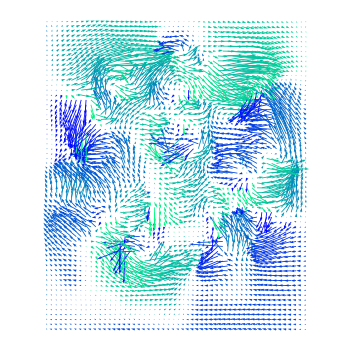

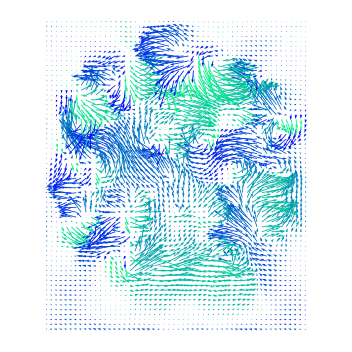

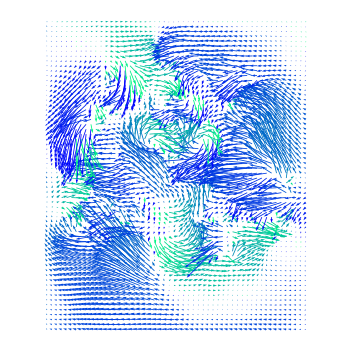

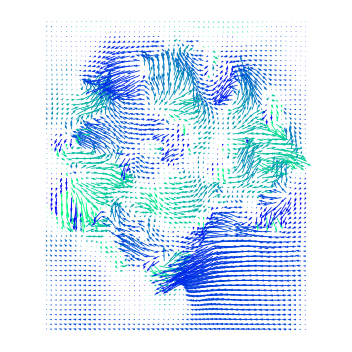

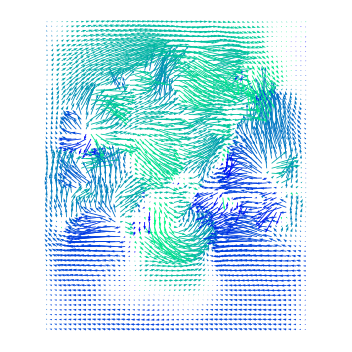

In [21]:
for i in range(5):
    val_input,_ = next(val_generator)
    val_pred = vxm_model.predict(val_input)
    ne.plot.flow([val_pred[1].squeeze()[::3,::3]], width = 5)

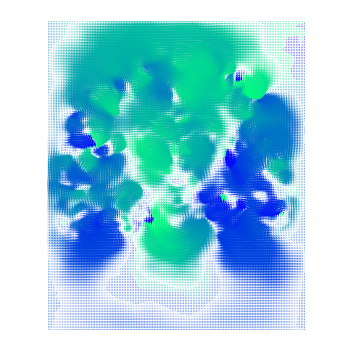

(<Figure size 360x360 with 1 Axes>, [<AxesSubplot:>])

In [22]:
ne.plot.flow([val_pred[1].squeeze()], width = 5)

## Evaluation 

In [23]:
#prediction from MSE+smoothness loss
with_smoothness_val_pred = vxm_model.predict(val_input)

#prediction from modelwith just MSE loss
vxm_model.load_weights("Desktop/registration_brain/brain_2d_no_smooth.h5")
without_smoothness_val_pred = vxm_model.predict(val_input)

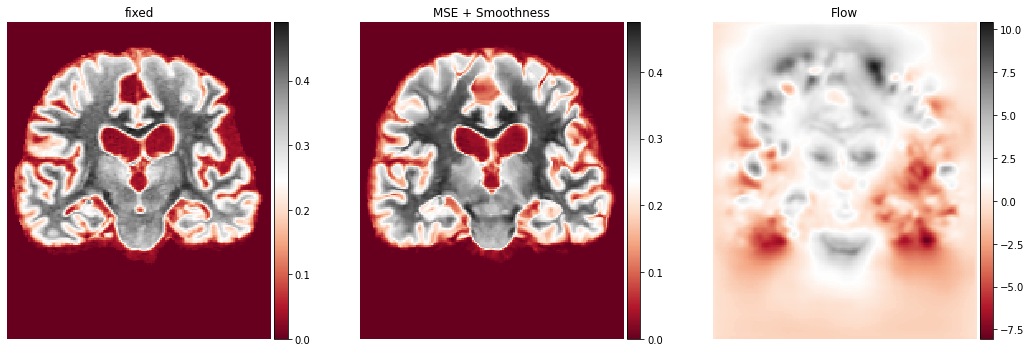

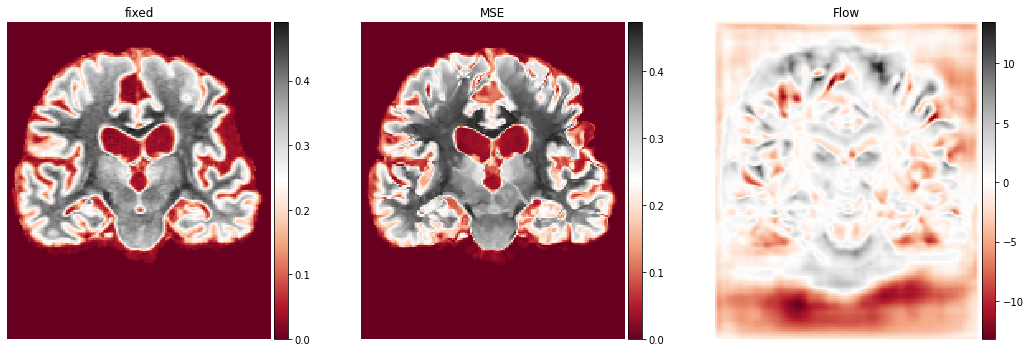

(<Figure size 1080x360 with 6 Axes>,
 array([<AxesSubplot:title={'center':'fixed'}>,
        <AxesSubplot:title={'center':'MSE'}>,
        <AxesSubplot:title={'center':'Flow'}>], dtype=object))

In [24]:
#visualise MSE + smoothness model output
images = [img[0,...,0] for img in [val_input[1], *with_smoothness_val_pred]]
titles = ["fixed", "MSE + Smoothness", "Flow"]
ne.plot.slices(images, titles=titles, cmaps = ["RdGy"], do_colorbars=True)

#visualise MSE model output
images = [img[0,...,0] for img in [val_input[1], *without_smoothness_val_pred]]
titles = ["fixed", "MSE", "Flow"]
ne.plot.slices(images, titles=titles, cmaps = ["RdGy"], do_colorbars=True)

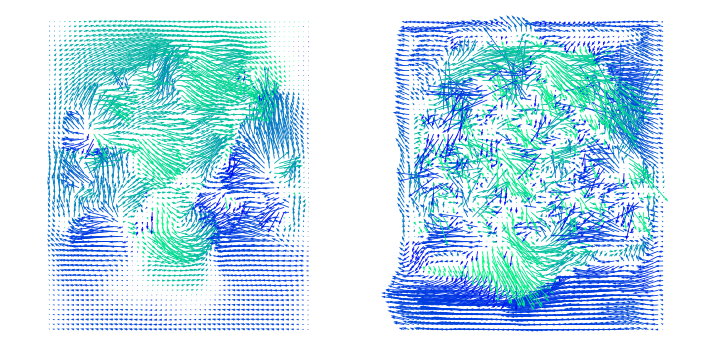

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>], dtype=object))

In [25]:
ne.plot.flow([img[1].squeeze()[::3,::3] for img in [with_smoothness_val_pred, without_smoothness_val_pred]], width = 10)

## Affine Registration of two random images 

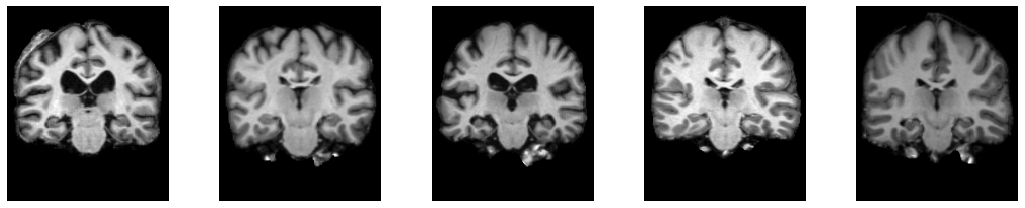

(<Figure size 1080x216 with 5 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>], dtype=object))

In [26]:
idx = [0,1,2,3,4]
images = [i for i in x_train[idx]]

ne.plot.slices(images, cmaps=["gray"])

In [27]:
image = x_train[0]
offset_image = x_train[1]

noise = 0.1
xoff, yoff, exoff, eyoff = chi2_shift(image, offset_image, noise, 
                                      return_error=True, upsample_factor ="auto" )

c:\anaconda\envs\vxm\lib\site-packages\image_registration\fft_tools\convolve_nd.py:269: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigarray[arrayslices] = array
c:\anaconda\envs\vxm\lib\site-packages\image_registration\fft_tools\convolve_nd.py:270: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bigkernel[kernslices] = kernel
c:\anaconda\envs\vxm\lib\site-packages\image_registration\fft_tools\convolve_nd.py:325: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[se

In [28]:
print("pixels shift by: ", xoff, yoff)

pixels shift by:  0.716796875 1.634765625


In [29]:
from scipy.ndimage import shift
corrected_image = shift(offset_image, shift=(xoff,yoff), mode = "constant")

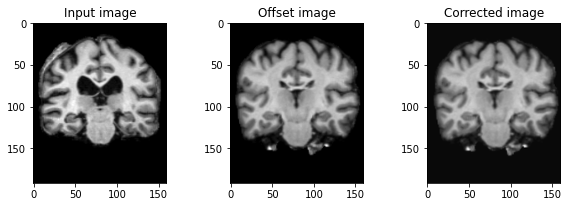

In [30]:
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(3,3,1)
ax1.imshow(image, cmap = "gray")
ax1.title.set_text("Input image")

ax2 = fig.add_subplot(3,3,2)
ax2.imshow(offset_image, cmap = "gray")
ax2.title.set_text("Offset image")

ax3 = fig.add_subplot(3,3,3)
ax3.imshow(corrected_image, cmap = "gray")
ax3.title.set_text("Corrected image")